In [1]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from torchvision.models import vgg16_bn
import PIL
import imageio
from superres import *
from superres.helpers import czi_predict_movie

In [2]:
#torch.cuda.set_device(0)

In [3]:
img_data = Path('/scratch/bpho/datasets/synth_newcrap_001/')
model_path = Path('/scratch/bpho/models')
nb_name = "synth_newcrap_0001_unet_mse"

In [4]:
#!ls {img_data}/lr_up/train/pair*

In [5]:
def get_src(size=128):
    hr_tifs = img_data/f'hr'
    lr_tifs = img_data/f'lr_up'

    def map_to_hr(x):
        hr_name = x.relative_to(lr_tifs)
        return hr_tifs/hr_name
    print(lr_tifs)
    src = (ImageImageList
            .from_folder(lr_tifs)
            .split_by_folder()
            .label_from_func(map_to_hr))
    return src

def _gaussian_noise_gray(x, gauss_sigma=1.):
    c,h,w = x.shape
    noise = torch.zeros((1,h,w))
    noise.normal_(0, gauss_sigma)
    img_max = np.minimum(1.1 * x.max(), 1.)
    x = np.minimum(np.maximum(0,x+noise.repeat((3,1,1))), img_max)
    return x

gaussian_noise_gray = TfmPixel(_gaussian_noise_gray)


def get_data(bs, size, tile_size=None, noise=None, max_zoom=8.):
    if tile_size is None: tile_size = size
    src = get_src(tile_size)
    
    tfms = [[rand_resize_crop(size=size)],[]]
    tfms = get_transforms(flip_vert=True, max_zoom=max_zoom)
    y_tfms = [[t for t in tfms[0]], [t for t in tfms[1]]]
    
    if not noise is None:
        tfms[0].append(gaussian_noise_gray(gauss_sigma=noise))
    data = (src
            .transform(tfms, size=size)
            .transform_y(y_tfms, size=size)
            .databunch(bs=bs).normalize(imagenet_stats, do_y=True))
    data.c = 3
    return data


In [6]:
!ls {img_data}

hr  lr	lr_up


In [7]:
bs = 96
size = 128
data = get_data(bs, size, max_zoom=4)
data

/scratch/bpho/datasets/synth_newcrap_001/lr_up


ImageDataBunch;

Train: LabelList (8255 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /scratch/bpho/datasets/synth_newcrap_001/lr_up;

Valid: LabelList (1693 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /scratch/bpho/datasets/synth_newcrap_001/lr_up;

Test: None

In [8]:
fn = list((img_data/'hr'/'train').glob('*.tif'))[0]

In [9]:
#PIL.Image.open(fn)

In [10]:
feat_loss = F.mse_loss

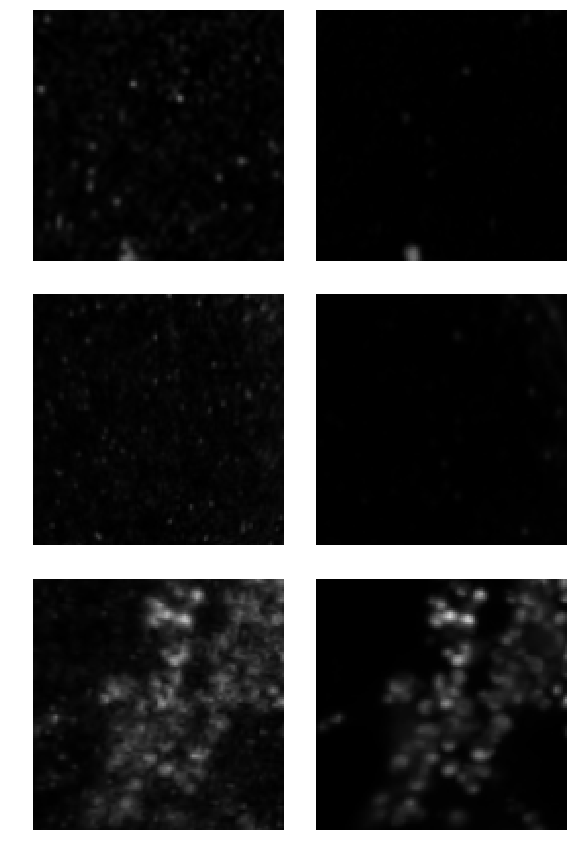

In [11]:
data.show_batch(3)

In [ ]:
arch = models.resnet18
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, 
                     metrics=superres_metrics, #callback_fns=LossMetrics, 
                     blur=True, blur_final=True, norm_type=NormType.Weight, 
                     self_attention=True, last_cross=True, bottle=True,
                     #y_range=(0.,1.),
                     model_dir=model_path)
gc.collect()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [12]:
lr = 1e-3

In [13]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9, cycle_len=10):
    learn.fit_one_cycle(cycle_len, lrs, pct_start=pct_start)
    learn.save(save_name)
    num_rows = min(learn.data.batch_size, 3)
    learn.show_results(rows=num_rows, imgsize=5)

In [ ]:
do_fit(f'{nb_name}.0', lr, cycle_len=6)

In [ ]:
learn.unfreeze()

In [ ]:
do_fit(f'{nb_name}.1', slice(1e-5,lr))

In [18]:
bs = 24
size = 256
data = get_data(bs, size, max_zoom=4.)

arch = models.resnet18
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, 
                     metrics=superres_metrics,# callback_fns=LossMetrics, 
                     blur=True, blur_final=True, norm_type=NormType.Weight, 
                     self_attention=True, last_cross=True, bottle=True, 
                     #y_range=(0.,1.),
                     model_dir=model_path)

learn = learn.load(f'{nb_name}.1')
gc.collect()


/scratch/bpho/datasets/synth_newcrap_001/lr_up


0

epoch,train_loss,valid_loss,mse_loss,ssim,psnr,time
0,0.044542,0.029468,0.029468,0.454707,15.380775,02:20
1,0.039400,0.028899,0.028899,0.467932,15.466775,02:14
2,0.037245,0.028260,0.028260,0.476951,15.562922,02:15
3,0.039095,0.028225,0.028225,0.472410,15.569449,02:15


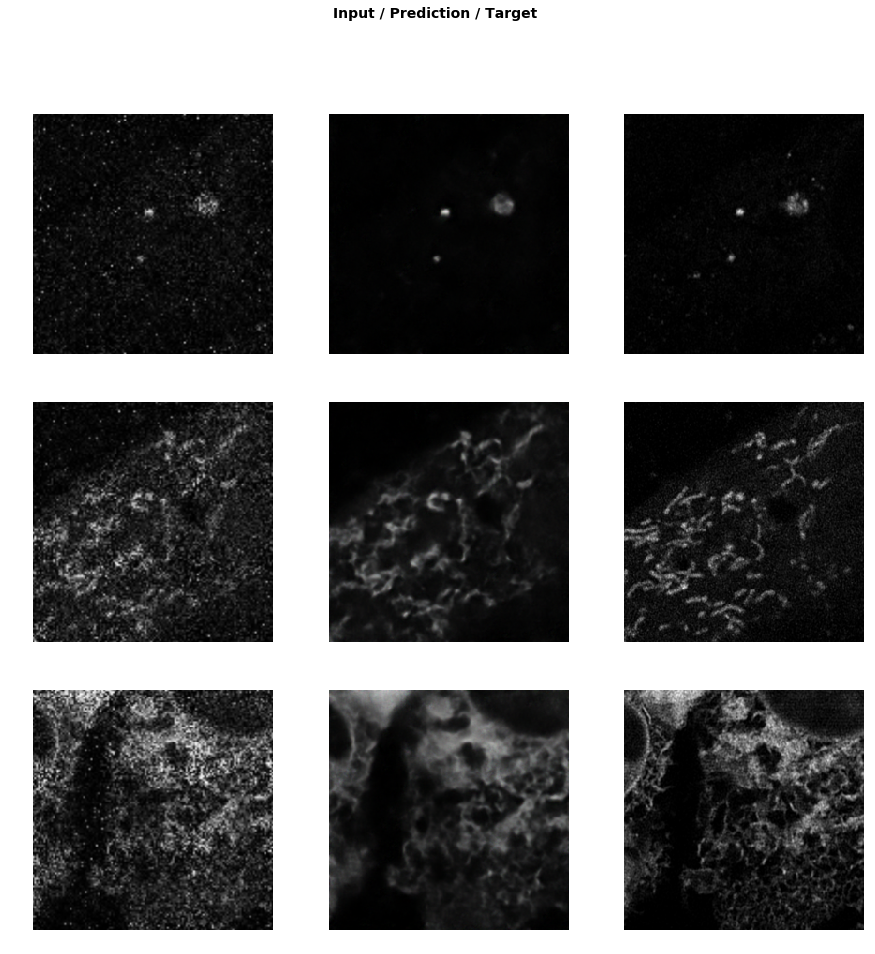

In [19]:
do_fit(f'{nb_name}.2', lr/100, cycle_len=4)

In [20]:
learn.unfreeze()

epoch,train_loss,valid_loss,mse_loss,ssim,psnr,time
0,0.038436,0.028351,0.028351,0.472024,15.548613,02:19
1,0.037508,0.027849,0.027849,0.479963,15.629271,02:19
2,0.037762,0.027793,0.027793,0.485094,15.637199,02:18
3,0.036346,0.027543,0.027543,0.485496,15.678250,02:18


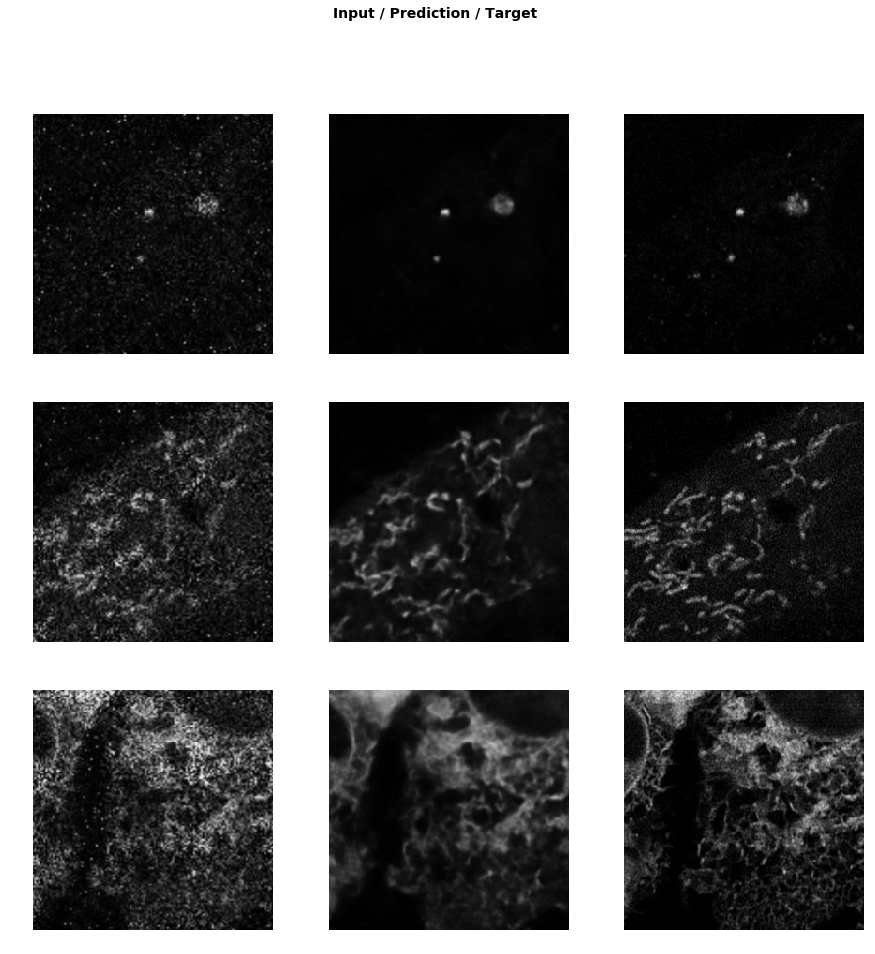

In [21]:
do_fit(f'{nb_name}.3', slice(1e-5,lr/10), cycle_len=4)

In [22]:
print('cool')

cool


In [23]:
bs = 4
size = 512
data = get_data(bs, size, max_zoom=2.)

arch = models.resnet18
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, 
                     metrics=superres_metrics, #callback_fns=LossMetrics, 
                     blur=True, blur_final=True, norm_type=NormType.Weight, 
                     self_attention=True, last_cross=True, bottle=True,
                     #y_range=(0.,1.),
                     model_dir=model_path)

learn = learn.load(f'{nb_name}.3')
gc.collect()

/scratch/bpho/datasets/synth_newcrap_001/lr_up


0

epoch,train_loss,valid_loss,mse_loss,ssim,psnr,time
0,0.040161,0.031736,0.031736,0.422507,15.555628,09:52
1,0.038159,0.031726,0.031726,0.425684,15.562859,09:47
2,0.040315,0.032006,0.032006,0.421879,15.514222,09:47
3,0.039553,0.031933,0.031933,0.426078,15.531708,09:47
4,0.042269,0.031745,0.031745,0.434963,15.569256,09:47
5,0.039180,0.031887,0.031887,0.427252,15.537173,09:47
6,0.038528,0.031921,0.031921,0.430338,15.535650,09:47
7,0.035990,0.032247,0.032247,0.436185,15.501875,09:48
8,0.039552,0.032157,0.032157,0.433908,15.488818,09:47
9,0.039347,0.031749,0.031749,0.431996,15.552722,09:47


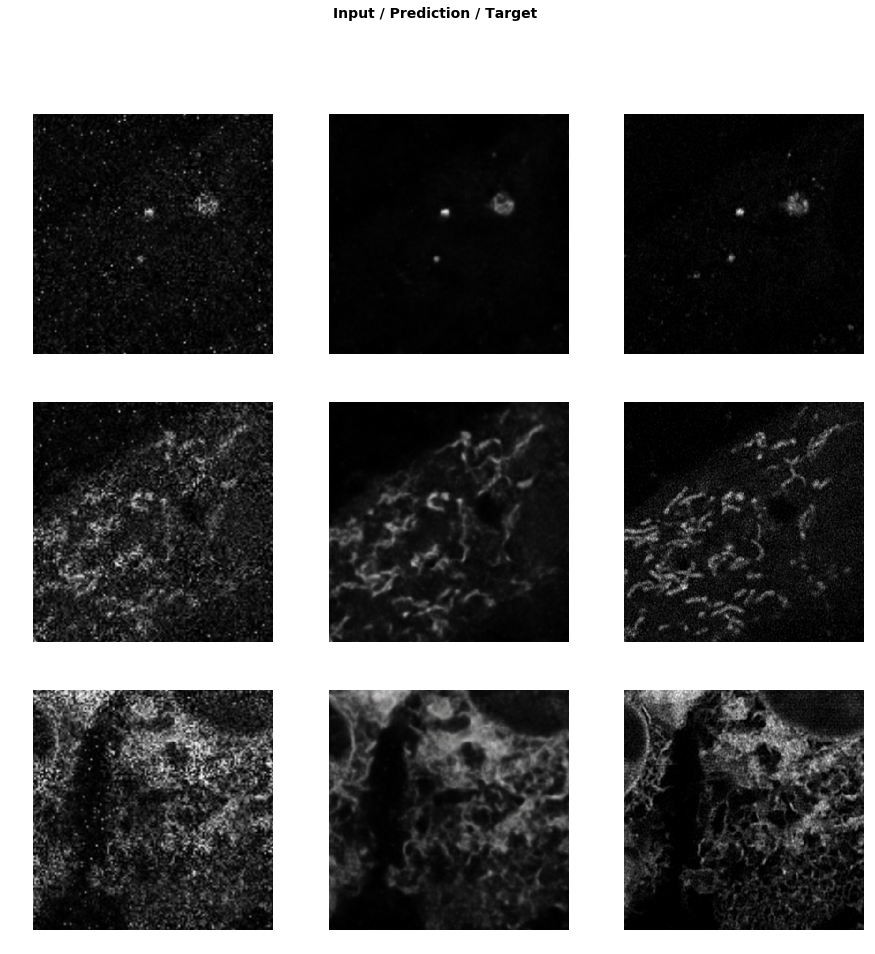

In [24]:
do_fit(f'{nb_name}.4', lr/100)

In [25]:
learn.unfreeze()

epoch,train_loss,valid_loss,mse_loss,ssim,psnr,time
0,0.036456,0.031629,0.031629,0.437322,15.577764,10:04
1,0.036321,0.031809,0.031809,0.434741,15.552238,10:05
2,0.037250,0.031793,0.031793,0.432694,15.552519,10:04
3,0.037168,0.032208,0.032208,0.435706,15.491284,10:05
4,0.037992,0.031471,0.031471,0.435258,15.599140,10:04
5,0.036557,0.031430,0.031430,0.437520,15.619719,10:04
6,0.033073,0.031645,0.031645,0.438700,15.572497,10:04
7,0.038747,0.031385,0.031385,0.436979,15.610589,10:04
8,0.036926,0.031794,0.031794,0.439355,15.544109,10:04
9,0.039039,0.031488,0.031488,0.442283,15.624068,10:04


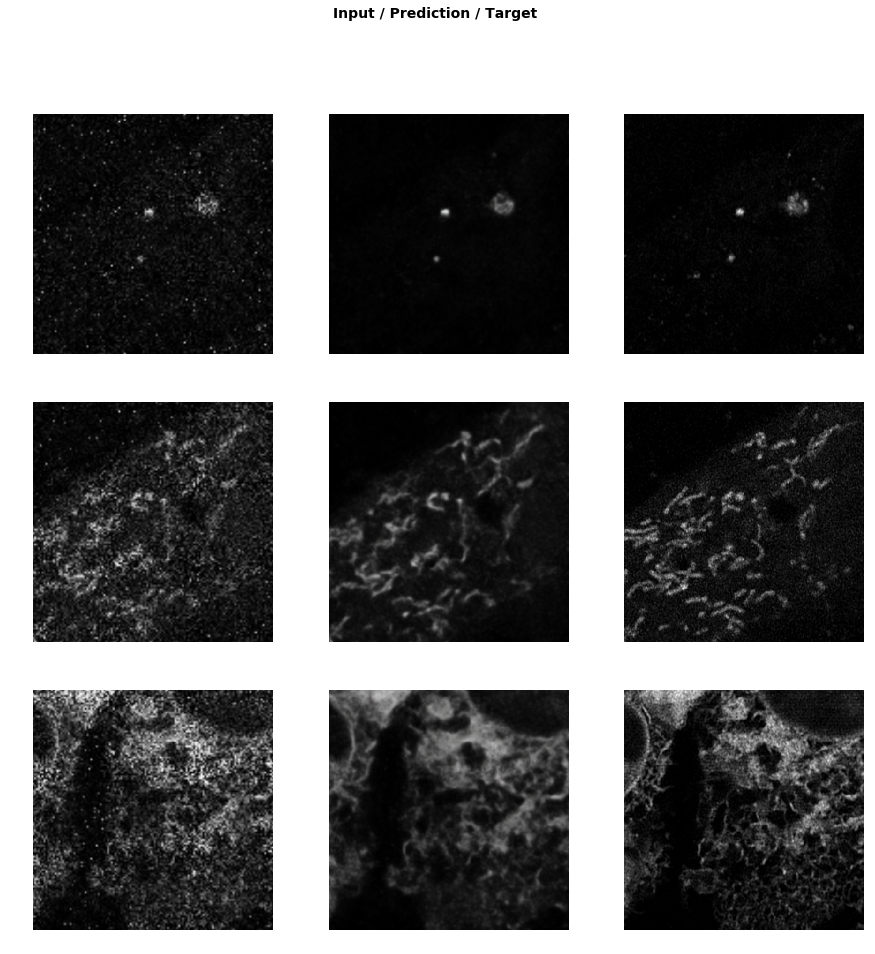

In [26]:
do_fit(f'{nb_name}.5', slice(1e-6,lr/100))

In [ ]:
bs = 2
size = 1024
data = get_data(bs, size, max_zoom=2.)

arch = models.resnet18
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, 
                     metrics=superres_metrics, callback_fns=LossMetrics, 
                     blur=True, blur_final=True, norm_type=NormType.Weight, 
                     self_attention=True, last_cross=True, bottle=True,
                     #y_range=(0.,1.),
                     model_dir=model_path)
gc.collect()

learn = learn.load(f'{nb_name}.5')

In [ ]:
do_fit(f'{nb_name}.6', lr/100, cycle_len=4)

In [ ]:
learn.unfreeze()

In [ ]:
do_fit(f'{nb_name}.7', slice(1e-6,lr/100), cycle_len=2)

In [ ]:
print('cool')

In [14]:
!ls /scratch/bpho/models/{nb_name}*

/scratch/bpho/models/synth_newcrap_0001_unet_mse.0.pth
/scratch/bpho/models/synth_newcrap_0001_unet_mse.1.pth
/scratch/bpho/models/synth_newcrap_0001_unet_mse.2.pth
/scratch/bpho/models/synth_newcrap_0001_unet_mse.3.pth
/scratch/bpho/models/synth_newcrap_0001_unet_mse.4.pth
/scratch/bpho/models/synth_newcrap_0001_unet_mse.5.pth


In [16]:
#movie_files = list(Path('/scratch/bpho/datasets/movies_001/test').glob('*.czi'))
movie_files = list(Path('/scratch/bpho/datasources/low_res_test/').glob('low res confocal*.czi'))

In [17]:
fn = movie_files[0]
len(movie_files)

10

In [18]:
with czifile.CziFile(fn) as czi_f:
    proc_axes, proc_shape = get_czi_shape_info(czi_f)
    channels = proc_shape['C']
    depths = proc_shape['Z']
    times = proc_shape['T']
    x,y = proc_shape['X'], proc_shape['Y']
    data = czi_f.asarray()
    preds = []
    origs = []
    idx = build_index(proc_axes, {'T': 0, 'C': 0, 'Z':0, 'X':slice(0,x),'Y':slice(0,y)})
    img = data[idx].astype(np.float32)
    img /= (img.max() * 1.5)

In [19]:
def image_from_tiles(learn, img, tile_sz=128, scale=4):
    pimg = PIL.Image.fromarray((img*255).astype(np.uint8), mode='L').convert('RGB')
    cur_size = pimg.size
    new_size = (cur_size[0]*scale, cur_size[1]*scale)
    in_img = Image(pil2tensor(pimg.resize(new_size, resample=PIL.Image.BICUBIC),np.float32).div_(255))
    c, w, h = in_img.shape
    
    in_tile = torch.zeros((c,tile_sz,tile_sz))
    out_img = torch.zeros((c,w,h))
    
    for x_tile in range(math.ceil(w/tile_sz)):
        for y_tile in range(math.ceil(h/tile_sz)):
            x_start = x_tile

            x_start = x_tile*tile_sz
            x_end = min(x_start+tile_sz, w)
            y_start = y_tile*tile_sz
            y_end = min(y_start+tile_sz, h)
            
            
            in_tile[:,0:(x_end-x_start), 0:(y_end-y_start)] = in_img.data[:,x_start:x_end, y_start:y_end]
            
            out_tile,_,_ = learn.predict(Image(in_tile))

            out_x_start = x_start
            out_x_end = x_end
            out_y_start = y_start
            out_y_end = y_end

            #print("out: ", out_x_start, out_y_start, ",", out_x_end, out_y_end)
            in_x_start = 0
            in_y_start = 0
            in_x_end = x_end-x_start
            in_y_end = y_end-y_start
            #print("tile: ",in_x_start, in_y_start, ",", in_x_end, in_y_end)
           
            out_img[:,out_x_start:out_x_end, out_y_start:out_y_end] = out_tile.data[:,
                                                                                  in_x_start:in_x_end, 
                                                                                  in_y_start:in_y_end]
    return out_img


In [20]:
def czi_predict_movie(learn, czi_in, orig_out='orig.tif', pred_out='pred.tif', size=128):
    with czifile.CziFile(czi_in) as czi_f:
        proc_axes, proc_shape = get_czi_shape_info(czi_f)
        channels = proc_shape['C']
        depths = proc_shape['Z']
        times = proc_shape['T']
        x,y = proc_shape['X'], proc_shape['Y']
        data = czi_f.asarray()
        preds = []
        origs = []
        img_max = None
        for t in progress_bar(list(range(times))):
            idx = build_index(proc_axes, {'T': t, 'C': 0, 'Z':0, 'X':slice(0,x),'Y':slice(0,y)})
            img = data[idx].astype(np.float32)
            if img_max is None: img_max = img.max() * 1.0
            img /= img_max
            out_img = image_from_tiles(learn, img, tile_sz=size).permute([1,2,0])
            pred = (out_img[None]*255).cpu().numpy().astype(np.uint8)
            preds.append(pred)
            orig = (img[None]*255).astype(np.uint8)
            origs.append(orig)

        all_y = np.concatenate(preds)
        #print(all_y.shape)
        imageio.mimwrite(pred_out, all_y) #, fps=30, macro_block_size=None) # for mp4
        all_y = np.concatenate(origs)
        #print(all_y.shape)
        imageio.mimwrite(orig_out, all_y) #, fps=30, macro_block_size=None)


In [21]:
bs=1
size=1024
scale = 4

data = get_data(bs, size, tile_size=128)

arch = models.resnet18
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, 
                     metrics=superres_metrics, callback_fns=LossMetrics, 
                     blur=True, blur_final=True, norm_type=NormType.Weight, 
                     self_attention=True, last_cross=True, bottle=True,
                     #y_range=(0.,1.),
                     model_dir=model_path)
gc.collect()
learn = learn.load(f'{nb_name}.5')


/scratch/bpho/datasets/synth_newcrap_001/lr_up


In [22]:
#learn.export(model_path/'paired_001_unet.8.pkl')
#learn = load_learner(model_path, 'paired_001_unet.8.pkl')

In [23]:
for fn in movie_files:
    pred_name = f'{fn.stem}_pred.tif'
    orig_name = f'{fn.stem}_orig.tif'
    czi_predict_movie(learn, fn, size=size, orig_out=orig_name, pred_out=pred_name )

In [ ]:
learn.pred_batch()

In [ ]:
import skimage.util as u

In [ ]:
u.img_as_ubyte